In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from astropy.io import fits

In [3]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [4]:
from scipy.ndimage.filters import gaussian_filter

In [5]:
figsize(8,6)

In [6]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [7]:
def get_data(bank='A', session=5):
    fnames = glob.glob('/data2/GBT/S140/Daisy/*/*_0'+str(session)+'_*'+bank+'*.rfireduced_new.npz')
    fnames.sort()
    calibrations = np.load('/home/mabitbol/GBT-S140/calibrations/calibration_3C295_0'+str(session)+'_'+bank+'.npy').item()
    fdiode = calibrations['freqs']
    pdiode = calibrations['pdiode']
    pdiode1 = calibrations['pdiode1']
    meanpower = 0.5 * (pdiode + pdiode1)
    calibrated = [] 
    calibrated2 = [] 
    ras = []
    decs = []
    azs = []
    els = []
    raw = []
    raw2 = []
    for fname in fnames:
        nz = np.load(fname)
        ra = nz['sra']
        dec = nz['sdec']
        mask = nz['valid']
        az = nz['AZIMUTH'][::8]
        el = nz['ELEVATIO'][::8]
        freqs = nz['freqs']
            
        gain = meanpower / (nz['xxon'] - nz['xxoff'])
        calibd = nz['xxoff'] * gain
        
        calibd2 = nz['xxoff'] / gain / np.nanmean(1. / gain**2, 0)
        calibrated2 = np.concatenate([calibrated2, np.nanmean(calibd2 - np.nanmedian(calibd2, 0), 1)])
        
        mask[:200] = False
        mask[400:] = False
    
        calibd = calibd[:, mask]
        calibrated = np.concatenate([calibrated, np.nanmean(calibd - np.nanmedian(calibd, 0), 1)])
        raw = np.concatenate([raw, np.nanmean(calibd, 1)])

        ras = np.concatenate([ras, ra])
        decs = np.concatenate([decs, dec])
        azs = np.concatenate([azs, az])
        els = np.concatenate([els, el])
    return raw, calibrated, ras, decs, azs, els, calibrated2

In [8]:
raw, calib, ra, dec, azs, els, calib2 = get_data('A')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: Mean of empty slice
/usr/lib64/python2.7/site-packages/numpy/lib/nanfunctions.py:879: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice


In [9]:
ts = np.arange(len(calib))
tmask = (ts < 42000) | (ts > 50000 )

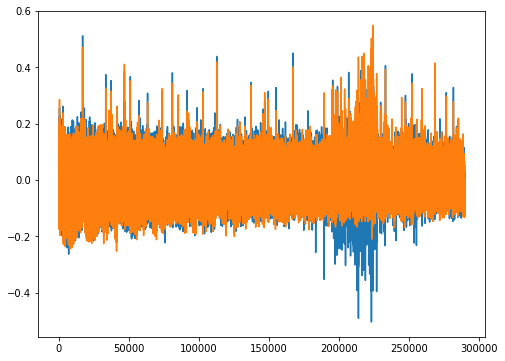

In [10]:
plot(calib[tmask])
plot(calib2[tmask])

In [13]:
session = 5
bank = 'A'

In [16]:
smth = 60.
pixbeam = 1.
removeplane = True

In [22]:
ras = ra[tmask]
decs = dec[tmask]
calibrated = calib2[tmask]
    
c = coordinates.SkyCoord(frame='fk5', ra=ras*u.degree, dec=decs*u.degree)
decs = c.galactic.b.deg
ras = c.galactic.l.deg
rc = 107.2
dc = 5.2

if bank == 'A':
    cfreq = 4.575
elif bank == 'B':
    cfreq = 5.625
elif bank == 'C':
    cfreq = 6.125
elif bank == 'D':
    cfreq = 7.175
beam = 12.6 / cfreq

# units
# beam and pixbeam are in arcminutes
beamarea = np.pi / (4. * np.log(2)) * beam**2
pixelarea = pixbeam**2
units = pixelarea / beamarea

# ras and decs are in degrees 
nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))

datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
mask = hits == 0
signal = np.zeros_like(datamap)
signal[~mask] = datamap[~mask] / hits[~mask] * units

radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)

rmask = radius <= 1.
insidedata = np.zeros_like(calibrated)
insidedata[rmask] = 10.
innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
innerregion = innermap > 0

annulus = (radius >= 80./60.) & (radius <= 2.)
annulus = radius >= 1.
outerdata = np.zeros_like(calibrated)
outerdata[annulus] = 10.
outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
outerregion = outermap > 0

rabinsc = (rabins[1:] + rabins[:-1]) / 2.
decbinsc = (decbins[1:] + decbins[:-1]) / 2.
if removeplane:
    X, Y = np.meshgrid(rabinsc, decbinsc)
    XX = X.flatten()
    YY = Y.flatten()
    Z = signal.flatten()
    masks = ~np.isnan(Z) * ~innerregion.flatten() #* regionregion.flatten()
    data = np.c_[XX[masks], YY[masks], Z[masks]]
    data2 = np.c_[XX, YY, Z]
    A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
    C, _, _, _ = linalg.lstsq(A, data[:, 2])
    res = C[0] * X + C[1] * Y + C[2]
    signal -= res

signal -= np.nanmedian(signal[outerregion])
if smth is None:
    smth = beam
if smth > 0:
    sigma = smth / pixbeam / (2. * np.sqrt(2. * np.log(2)))
    signal = gaussian_filter(signal, sigma)
    shits = gaussian_filter(hits, sigma)
    mask = shits < 1
signal[mask] = np.nan
print np.nansum(signal[innerregion]), np.nanstd(signal[outerregion]) * np.sqrt(innerregion.sum())

26.6296423013 0.125018811117


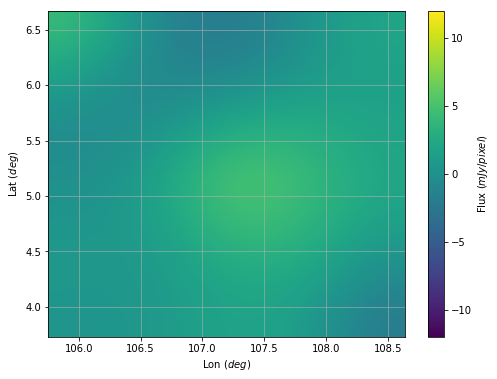

In [21]:
figure()
pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
clim(-12, 12)
cb = colorbar()
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid(alpha=0.7)
#title('$6.2~GHz$')

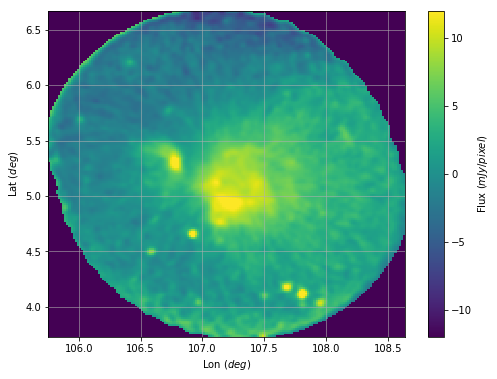

In [48]:
figure()
pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
clim(-12, 12)
cb = colorbar()
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid(alpha=0.7)
#title('$6.2~GHz$')